In [13]:
import pandas as pd
import numpy as np
import ftplib
import requests
import matplotlib.pyplot as plt
import os
import re

# Type of files and their significance can be found in the doc: 
https://www.ncdc.noaa.gov/swdiws/csv/nx3tvs and https://www.ncdc.noaa.gov/swdiws

1) Hail: events where hail has been recorded
2) Meso and MDA: legacy mesocyclone and Mesocyclone Detection Algorithm. Legacy stops at 2010, and MDA doesn't start until 2007. Maybe use Meso until 2010 and continue with MDA after
3) TVS: Tornadic Vortex Signature Overlay- A product which shows an intense gate to gate azimuthal shear associated with tornadic-scale rotation.
4) Structure: Storm Cell Structure Information
5) nldn: Lightning strikes data. They give the count of lightning strikes within 0.1 in lat and lon of a given region
All the "tiles" files are Lightning strikes data. Maybe what type of event provoqued that strike? 

# Connect and get all the file names

In [2]:
# connect to the server
ftp = ftplib.FTP('ftp.ncdc.noaa.gov', timeout=30) #pass the url without protocol
ftp.login() #pass credentials if anonymous access is not allowed

# switch to the directory containing the data
ftp.cwd('/pub/data/swdi/database-csv/v2/')
ftp.pwd()

httpurl = 'https://www.ncei.noaa.gov/pub/data/swdi/database-csv/v2/'
# get the list of files in this ftp dir
all_files= ftp.nlst()

In [22]:
#all_files

## Example with selecting all hail files

In [57]:
pattern = r"hail-[0-9]{4}\."
hail_files = [i for i in all_files if bool(re.match(pattern, i))]
hail_files.sort()
print(hail_files)

['hail-1995.csv.gz', 'hail-1996.csv.gz', 'hail-1997.csv.gz', 'hail-1998.csv.gz', 'hail-1999.csv.gz', 'hail-2000.csv.gz', 'hail-2001.csv.gz', 'hail-2002.csv.gz', 'hail-2003.csv.gz', 'hail-2004.csv.gz', 'hail-2005.csv.gz', 'hail-2006.csv.gz', 'hail-2007.csv.gz', 'hail-2008.csv.gz', 'hail-2009.csv.gz', 'hail-2010.csv.gz', 'hail-2011.csv.gz', 'hail-2012.csv.gz', 'hail-2013.csv.gz', 'hail-2014.csv.gz', 'hail-2015.csv.gz', 'hail-2016.csv.gz', 'hail-2017.csv.gz', 'hail-2018.csv.gz', 'hail-2019.csv.gz', 'hail-2020.csv.gz', 'hail-2021.csv.gz', 'hail-2022.csv.gz', 'hail-2023.csv.gz']


## This downloads one hail file from 2023, stores it on disk, and then reads them into a csv 

In [60]:
query_parameters = {"downloadformat": "csv"}
response = requests.get(httpurl+hail_files[-1], params=query_parameters)

In [61]:
response.url

'https://www.ncei.noaa.gov/pub/data/swdi/database-csv/v2/hail-2023.csv.gz?downloadformat=csv'

In [62]:
response.ok

True

In [63]:
response.status_code

200

In [64]:
with open(r'../weather_data/hail/' 
              + hail_files[-1], "wb") as file:
    file.write(response.content)

In [65]:
hail_2023 = pd.read_csv(r'../weather_data/hail/' 
              + hail_files[-1], skiprows=2, parse_dates=['#ZTIME'])
hail_2023.head()

,#ZTIME,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0,2023-01-01 00:01:45,-76.98093,33.78684,KRAX,K7,135,146,-999,-999,-999.0
1,2023-01-01 00:01:45,-75.84620,36.05329,KRAX,D8,131,79,-999,-999,-999.0
2,2023-01-01 00:03:25,-76.96301,33.80832,KLTX,H7,74,98,0,10,0.5
3,2023-01-01 00:04:05,-64.43412,19.83733,TJUA,L0,139,42,-999,-999,-999.0
4,2023-01-01 00:06:21,-77.72771,32.79592,KMHX,X9,126,200,-999,-999,-999.0


# Data looks great, so we can do it for all of any type of file

Create a dictionnary for type of events, and their name in the files. And then create directories for each type to store them

In [4]:
event_types = {'hail':'hail', 'storm_structure':'structure', 'tornados':'tvs', 'lightning':'nldn-tiles', 'mesocyclone':'mda'}
for event in event_types:
    path = '../weather_data/'+event
    if not os.path.exists(path):
        os.mkdir(path)

### Given a year and event type, dowloand and save the file 

In [2]:
def download_file(year, event_type, all_files, httpurl):
    event_name = event_types[event_type]
    pattern = event_name+"-"+str(year)
    file_name = [fname for fname in all_files if pattern in fname]
    if len(file_name) == 0:
        print("No file in that year for that event type" )
        return 
    file_name = file_name[0]
    print("Considering file ", file_name)
    if os.path.exists('../weather_data/{}/{}'.format(event_type, file_name)):
        print("file already exists")
        return
    query_parameters = {"downloadformat": "csv"}
    print("Getting the response from the URL .....")
    response = requests.get(httpurl+file_name, params=query_parameters)
    if response.ok:
        print("Downloaded succesfully")
    with open(r'../weather_data/{}/{}'.format(event_type, file_name), "wb") as f:
        f.write(response.content)
    print('Saved in folder')

In [28]:
download_file(2023, 'tornados', all_files, httpurl)

Considering file  tvs-2023.csv.gz
Getting the response from the URL .....
Downloaded succesfully
Saved in folder


### Short function that reads csv files with for a given year and type

In [3]:
def read_weather(year, event_type):
    files = os.listdir('../weather_data/'+event_type)
    file_name = [fname for fname in files if str(year) in fname]
    if len(file_name) == 0:
        return "No file in that year for that event type"
    if len(file_name) > 1:
        return "Multiple files with that year in their name"
    if event_type == 'lightning':
        return pd.read_csv(r'../weather_data/'+event_type+'/'
                  + file_name[0], skiprows=2, parse_dates=['#ZDAY'])
    return pd.read_csv(r'../weather_data/'+event_type+'/'
                  + file_name[0], skiprows=2, parse_dates=['#ZTIME'])

In [21]:
lighning = read_weather(2023, 'lightning')
lightning.head()

,#ZDAY,CENTERLON,CENTERLAT,TOTAL_COUNT
0,2023-01-01,-76.0,33.7,1
1,2023-01-01,-78.8,29.6,10
2,2023-01-01,-76.6,30.3,2
3,2023-01-01,-112.7,33.8,4
4,2023-01-01,-72.2,37.0,1


In [29]:
t2 = tornados.copy()
t2 = t2.sort_values('WSR_ID')
t2

,#ZTIME,LON,LAT,WSR_ID,CELL_ID,CELL_TYPE,RANGE,AZIMUTH,AVGDV,LLDV,MXDV,MXDV_HEIGHT,DEPTH,BASE,TOP,MAX_SHEAR,MAX_SHEAR_HEIGHT
54364,2023-07-08 23:29:23,-97.91546,46.26774,KABR,F0,TVS,53,23,30,52,52,7,8.6,7.0,15.6,15,7.0
54373,2023-07-08 23:33:58,-97.90505,46.24633,KABR,F0,TVS,52,24,28,52,52,7,5.7,6.8,12.5,16,6.8
61287,2023-07-26 05:10:46,-97.64719,44.78005,KABR,X9,TVS,52,141,30,35,72,16,23.8,6.8,30.6,22,15.8
54372,2023-07-08 23:33:58,-97.90505,46.24633,KABR,F0,TVS,52,24,28,52,52,7,5.7,6.8,12.5,16,6.8
52568,2023-07-04 05:06:38,-99.09728,44.75782,KABR,Z5,TVS,51,215,37,58,75,14,22.6,4.5,27.1,25,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89002,2023-10-20 21:19:45,-66.59820,17.97947,TSJU,D9,TVS,38,219,48,73,73,5,12.7,5.0,17.7,30,5.0
17652,2023-04-08 00:17:24,-66.55405,18.72312,TSJU,D0,TVS,26,305,52,35,105,12,8.8,3.1,11.9,65,11.9
49359,2023-06-29 18:04:16,-65.60139,18.46348,TSJU,J2,TVS,33,91,57,95,95,4,11.5,4.2,15.7,46,4.2
79145,2023-08-26 07:11:30,-65.73861,18.14389,TSJU,T4,TVS,32,128,56,72,81,7,5.8,1.7,7.4,40,7.4


## Next steps: clean hail, and merge with power_outage

In [39]:
hail = read_weather(2023, 'hail')


In [46]:
cleaned_hail = hail[hail.SEVPROB>0]
cleaned_hail.head(10)

,#ZTIME,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
69,2023-01-01 00:52:41,-77.26754,32.93332,KLTX,F8,86,137,10,70,0.50
72,2023-01-01 00:54:50,-77.25763,32.95018,KMHX,X9,111,190,20,80,0.50
82,2023-01-01 00:58:06,-77.21046,32.95578,KLTX,F8,87,135,10,60,0.50
535,2023-01-01 04:40:43,-73.14962,39.24757,KDOX,K4,110,76,10,40,0.50
536,2023-01-01 04:40:43,-73.23647,39.42723,KDOX,B7,109,70,10,40,0.50
549,2023-01-01 04:45:50,-73.09689,39.35863,KDOX,K4,114,73,10,50,0.50
566,2023-01-01 04:51:14,-72.96105,39.28007,KDOX,H5,119,76,10,50,0.50
685,2023-01-01 06:03:14,-95.08126,30.58100,KPOE,Q2,114,253,10,60,0.75
747,2023-01-01 06:34:08,-95.16671,30.59302,KPOE,X3,118,254,60,60,1.75
1053,2023-01-01 18:18:25,-114.31347,32.72070,KYUX,F0,22,52,10,60,0.50


In [12]:
#cleaned_hail.to_csv('../weather_data/cleaned/hail-2023_sevprob0.csv')
cleaned_hail = pd.read_csv('../weather_data/cleaned/hail-2023_sevprob0.csv', parse_dates=['#ZTIME'])

In [13]:
hail_copy = cleaned_hail.copy()
hail_copy['DATE'] = hail_copy['#ZTIME'].dt.date
groups = hail_copy.groupby(['DATE', 'WSR_ID', 'CELL_ID'])

In [15]:
hail_agg = groups.agg({'LAT':['mean', 'min', 'max'], 'LON':['mean', 'min', 'max'], 'SEVPROB':'max', 'PROB':'max', 'MAXSIZE':'max'})
hail_agg.columns = hail_agg.columns.to_flat_index()
hail_agg.columns = [col[0]+'_'+col[1] for col in hail_agg.columns]
hail_agg = hail_agg.reset_index()
hail_agg.head()

,DATE,WSR_ID,CELL_ID,LAT_mean,LAT_min,LAT_max,LON_mean,LON_min,LON_max,SEVPROB_max,PROB_max,MAXSIZE_max
0,2023-01-01,KDOX,B7,39.427230,39.42723,39.42723,-73.236470,-73.23647,-73.23647,10,40,0.5
1,2023-01-01,KDOX,H5,39.280070,39.28007,39.28007,-72.961050,-72.96105,-72.96105,10,50,0.5
2,2023-01-01,KDOX,K4,39.303100,39.24757,39.35863,-73.123255,-73.14962,-73.09689,10,50,0.5
3,2023-01-01,KESX,I1,34.326947,34.31229,34.33716,-114.222727,-114.24935,-114.19123,30,60,0.5
4,2023-01-01,KESX,L1,36.999500,36.99950,36.99950,-115.004190,-115.00419,-115.00419,20,60,0.5


In [16]:
len(hail_agg)

396347

In [17]:
hail_agg.to_csv('../weather_data/cleaned/hail-2023.csv')

# Mesocyclones (mda)

In [25]:
download_file(2023, 'mesocyclone', all_files, httpurl)

Considering file  mda-2023.csv.gz


'file already exists'

In [26]:
mda = read_weather(2023, 'mesocyclone')


In [27]:
mda.head()

,#ZTIME,LON,LAT,WSR_ID,CELL_ID,STR_RANK,SCIT_ID,RANGE,AZIMUTH,LL_ROT_VEL,LL_DV,LL_BASE,DEPTH_KFT,DPTH_STMRL,MAX_RV_KFT,MAX_RV_KTS,TVS,MOTION_DEG,MOTION_KTS,MSI
0,2023-01-01 00:00:09,-80.62155,28.15406,KMLB,281,9L,Q7,3,35,51,66,0,1,100,0,58,N,-999,-999,7577
1,2023-01-01 00:00:09,-80.67428,28.15980,KMLB,287,5L,Q7,3,339,16,29,0,1,100,0,41,N,-999,-999,3357
2,2023-01-01 00:00:09,-80.63372,28.15980,KMLB,282,9L,Q7,3,21,55,55,0,1,100,0,55,N,-999,-999,6999
3,2023-01-01 00:00:09,-80.66190,28.21301,KMLB,285,6L,Q7,6,356,60,69,0,1,100,0,60,N,-999,-999,5016
4,2023-01-01 00:00:09,-80.72474,28.40717,KMLB,284,6L,Q7,18,348,46,68,1,3,100,1,46,N,-999,-999,5151


In [29]:
mda['DATE'] = mda['#ZTIME'].dt.date
groups = mda.groupby(['DATE', 'WSR_ID', 'CELL_ID'])

In [33]:
properties = {'LAT':['mean', 'min', 'max'], 'LON':['mean', 'min', 'max'], 'STR_RANK':'max', 'LL_ROT_VEL':'max', 'LL_DV':'max', 'LL_BASE':'max', 'DEPTH_KFT':'max', 'DPTH_STMRL':'max', 'MAX_RV_KFT':'max', 'MAX_RV_KTS':'max', 'TVS':'max', 'MSI':'max'}

In [34]:
mda_agg = groups.agg(properties)
mda_agg.columns = mda_agg.columns.to_flat_index()
mda_agg.columns = [col[0]+'_'+col[1] for col in mda_agg.columns]
mda_agg = mda_agg.reset_index()
mda_agg.head()

,DATE,WSR_ID,CELL_ID,LAT_mean,LAT_min,LAT_max,LON_mean,LON_min,LON_max,STR_RANK_max,LL_ROT_VEL_max,LL_DV_max,LL_BASE_max,DEPTH_KFT_max,DPTH_STMRL_max,MAX_RV_KFT_max,MAX_RV_KTS_max,TVS_max,MSI_max
0,2023-01-01,KBBX,8,39.56747,39.56747,39.56747,-121.57649,-121.57649,-121.57649,5L,42,38,0,1,25,0,42,N,3331
1,2023-01-01,KBBX,20,39.43755,39.43755,39.43755,-121.50157,-121.50157,-121.50157,5L,29,30,0,1,52,1,34,N,3960
2,2023-01-01,KBBX,26,39.41935,39.41935,39.41935,-121.74564,-121.74564,-121.74564,6L,36,47,0,1,37,1,52,N,5070
3,2023-01-01,KBBX,33,39.58663,39.58663,39.58663,-121.86254,-121.86254,-121.86254,5L,34,32,1,2,69,1,49,N,4141
4,2023-01-01,KBBX,43,39.52809,39.52809,39.52809,-121.48704,-121.48704,-121.48704,5L,38,29,0,1,36,1,46,N,4631


In [35]:
mda_agg.to_csv('../weather_data/cleaned/mda-2023.csv')

# Storm Structure

In [6]:
download_file(2023, 'storm_structure', all_files, httpurl)

Considering file  structure-2023.csv.gz
Getting the response from the URL .....
Downloaded succesfully
Saved in folder


In [4]:
storm = read_weather(2023, 'storm_structure')
storm.sample(10)

,#ZTIME,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,BASE_HEIGHT,TOP_HEIGHT,VIL,MAX_REFLECT,HEIGHT
14151364,2023-06-16 23:37:49,-89.18632,33.19813,KGWX,F0,60,226,6.0,21.9,17,52,11.0
26755654,2023-08-16 20:49:52,-82.18366,28.78189,KJAX,H3,105,194,13.5,22.7,16,50,13.5
9304718,2023-05-20 19:31:01,-86.40264,34.52461,KHTX,F9,29,213,2.4,12.8,7,49,3.4
9333471,2023-05-20 22:15:42,-105.21248,38.34191,KFTG,Z2,92,200,10.9,18.5,32,58,10.9
9568352,2023-05-22 22:14:13,-88.88095,33.83034,KBMX,S8,113,291,15.7,20.4,20,52,15.7
20265957,2023-07-18 02:35:08,-103.13000,43.99962,KUDX,C5,15,240,0.9,2.0,1,43,0.9
19562803,2023-07-11 16:03:21,-91.56473,33.52235,KLZK,P3,86,156,10.2,27.8,26,55,10.2
3173430,2023-03-10 21:13:34,-90.69818,29.19836,KLIX,O7,82,214,9.5,12.2,10,50,9.5
826283,2023-01-19 06:56:25,-78.65911,40.25523,KCCX,C0,50,217,4.4,9.3,2,43,4.4
38171423,2023-12-28 00:58:54,-75.69447,42.21852,KBGM,Q5,13,85,0.7,3.6,0,34,3.6


In [5]:
len(storm)

38232148

In [36]:
storm = read_weather(2023, 'storm_structure')
storm['DATE'] = storm['#ZTIME'].dt.date
groups = storm.groupby(['DATE', 'WSR_ID', 'CELL_ID'])

In [37]:
properties = {'LAT':'mean', 'LON':'mean', 'MAX_REFLECT':'max', 'VIL':'max', 'HEIGHT':'max'}

In [39]:
storm_agg = groups.agg(properties)
storm_agg.columns = storm_agg.columns.to_flat_index()
#storm_agg.columns = [col[0]+'_'+col[1] for col in storm_agg.columns]
storm_agg = storm_agg.reset_index()
storm_agg.head()

,DATE,WSR_ID,CELL_ID,LAT,LON,MAX_REFLECT,VIL,HEIGHT
0,2023-01-01,KAKQ,A0,37.246289,-76.526391,49,4,8.3
1,2023-01-01,KAKQ,A1,36.284680,-77.207420,38,1,7.5
2,2023-01-01,KAKQ,A2,37.617120,-77.131855,38,1,8.9
3,2023-01-01,KAKQ,A3,36.729292,-76.287232,44,1,9.8
4,2023-01-01,KAKQ,A4,36.622450,-76.749160,44,1,1.8


In [40]:
cols = list(storm_agg.columns)
cols.remove('WSR_ID')
cols.remove('CELL_ID')
cols

['DATE', 'LAT', 'LON', 'MAX_REFLECT', 'VIL', 'HEIGHT']

In [45]:
storm_agg = storm_agg[storm_agg.VIL>20]
cl_storm = storm_agg[cols]

In [46]:
len(storm_agg)

963706

In [47]:
cl_storm.to_csv('../weather_data/cleaned/structure-2023.csv')

(array([6.19534e+05, 4.01355e+05, 3.16046e+05, 2.56000e+05, 2.15651e+05,
        3.44031e+05, 1.42231e+05, 1.27178e+05, 1.14648e+05, 1.04681e+05,
        1.83017e+05, 8.15190e+04, 7.51340e+04, 6.96820e+04, 6.44700e+04,
        1.15829e+05, 5.22880e+04, 4.89540e+04, 4.60570e+04, 4.35570e+04,
        7.98830e+04, 3.64710e+04, 3.52170e+04, 3.32900e+04, 3.17960e+04,
        5.92220e+04, 2.78670e+04, 2.67130e+04, 2.56700e+04, 2.44940e+04,
        4.67280e+04, 2.18080e+04, 2.12380e+04, 2.03850e+04, 1.95740e+04,
        3.68580e+04, 1.73840e+04, 1.63770e+04, 1.57070e+04, 1.47090e+04,
        2.75290e+04, 1.24340e+04, 1.21480e+04, 1.12460e+04, 1.07140e+04,
        1.93120e+04, 8.83600e+03, 8.25200e+03, 7.82500e+03, 7.18300e+03,
        1.30060e+04, 5.80300e+03, 5.36900e+03, 5.22400e+03, 4.81100e+03,
        8.50500e+03, 3.83600e+03, 3.62600e+03, 3.24800e+03, 3.09300e+03,
        5.34500e+03, 2.41600e+03, 2.25400e+03, 2.03700e+03, 1.81100e+03,
        3.30800e+03, 1.38400e+03, 1.29300e+03, 1.14

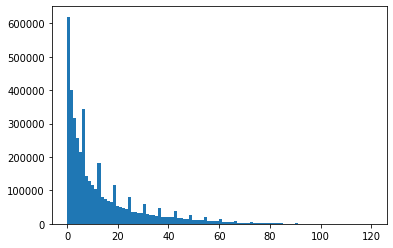

In [17]:
plt.hist(storm_agg.VIL_max, bins=100)
#plt.xscale('log')